In [2]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

# Домашка №1
# Усложненная
### Эта домашка нужна для лучшего понимания, но она будет сложнее из-за использования классов и, возможно, пока непривычной форме с классами.
Абстракции в этой домашке будут очень полезны для понимания того, что происходит в торче. Эта домашка прокачает вас гораздо сильнее, но и выполнить ее будет труднее. Вам нужно будет описать несколько слоев: `Linear`, `ReLU`, `BCELoss`.  Реализация `Sigmoid` уже есть в `our_library.layers`. Реализовав слои выше вы сможете сделать n-слойную нейронную сеть с любым количеством слоев. Это получается за счет того, что вы описали всю необходимую логику:
- Как нужно обработать входные данные и передать их дальше;
- Принять градиент с последующего слоя, сделать `backward` для текущего слоя и передать градиент предыдущему слою;
- Как обновить веса, если в слоев есть обучаемые веса.

Присылайте свои недоделанные сложные домашки, пусть они не пойдут совсем в стол. Я или ассистенты посмотрят, мы обсудим и доделаем.  
Поверьте, эта домашка стоит того, чтобы ее сделать!

# Датасет
Мы его просто загрузим и здесь пока будет какая-то торчовая магия, которую мы разберем на следующем занятии

### Некоторые магические трансформации, о которых пока не стоит заморачиваться
1. Перевод картинки в тензор
1. Нормализация картинки

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Загружаем датасет
Конкретно эта часть кода понадобится нам один раз за курс и будет только в этой домашке

In [4]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/home/tatiana/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Переводим его в два класса
Это нужно для упрощения задачи до бинарной классификации. В этой домашке мы будем отличать две цифры: 1 и 7.

In [5]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

## Оборачиваем в итератор данных
Далее в курсе мы поговорим о том, что это такое более подробно, а дальше в этой тетрадке будет несколько полезных деталей.  
Пока что будет достаточно понимать, что мы обернули наши данные в некоторую абстракцию, итерация по которой дает нам батчи данных из нашего датасета.  

In [6]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Порисуем данные

- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7  

Выбрал эти цифры, потому что на них хуже всего метрики

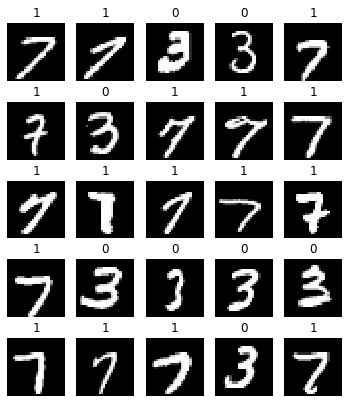

In [7]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# Итерация по датасету
- x - батч с данными
- y - батч с таргетами к этим данным

In [8]:
for x, y in train_loader:
    break

### train_loader это итератор, при проходе по которому будут выдаваться батчи данных

## Размерность x
- 128 - размер батча
- 1 - количество каналов, у нас чернобелые картинки, поэтому канал 1
- 28 - количество пикселей в длину
- 28 - количество пикселей в ширину

In [9]:
x.shape

torch.Size([128, 1, 28, 28])

In [10]:
x

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

## Просто выпрямим нашу матрицу в один вектор
### То есть каждая фича в векторе это значение пикселя
### Для нашей игрушечной задачи этого будет достаточно

In [11]:
x.view(x.shape[0], -1).numpy().shape

(128, 784)

### x.numpy()
Это перевод торчового тензора (некоторая абстракция, о которой мы будем говорить позже на курсе) в numpy массив

In [12]:
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = y.numpy()
    break

In [13]:
x

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], dtype=float32)

### Размерность
- количество примеров в батче
- количество фичей

In [14]:
x.shape

(128, 784)

# Таргеты
- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7

In [15]:
y

array([0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1])

# Итерация по эпохам

In [16]:
# количество эпох - полных проходов по датасету
epochs = 3

for n_epoch in range(epochs):
    
    dataset_passed_samples = 0
    
    for x, y in train_loader:
        
        # вот здесь мы могли бы как-то манипулировать с данными
        # например, учить, но пока этого делать не будет
        # только демонстрация
        
        time.sleep(0.01)
        
        dataset_passed_samples += x.shape[0]
        
        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]
        
        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')
        
    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета


# Небольшие пояснения по numpy

In [17]:
# таким образом мы создаем матрицу 64 на 512 с рандомными значениями
x = np.random.rand(64, 512)
x

array([[0.60061557, 0.68762835, 0.5621264 , ..., 0.81132223, 0.12022603,
        0.99051744],
       [0.09204908, 0.78941375, 0.94845913, ..., 0.00150301, 0.69213325,
        0.74190409],
       [0.3570879 , 0.10800445, 0.25372782, ..., 0.84036547, 0.71003958,
        0.24420565],
       ...,
       [0.31146548, 0.7815886 , 0.61611007, ..., 0.50869931, 0.5362698 ,
        0.7083657 ],
       [0.86472686, 0.74294016, 0.26522398, ..., 0.07235561, 0.84363665,
        0.58571681],
       [0.4566307 , 0.75093642, 0.07465183, ..., 0.55652001, 0.47002762,
        0.99769143]])

In [18]:
# большинство функций применяются к каждому элементу массива
# здесь мы каждый элемент массива возвели в квадрат и прибавили к получившемуся значению логарифм элемента матрицы 
x ** 2 + np.log(x)

array([[-0.14906114,  0.09832596, -0.26004245, ...,  0.44915379,
        -2.10392742,  0.97159698],
       [-2.37696035,  0.38670938,  0.84665814, ..., -6.50028176,
         0.11107164,  0.25188639],
       [-0.90226155, -2.21391785, -1.30711535, ...,  0.53229574,
         0.16172165, -1.3501082 ],
       ...,
       [-1.069456  ,  0.36445398, -0.10473802, ..., -0.41712321,
        -0.33553258,  0.15698717],
       [ 0.60241096,  0.25482031, -1.25683683, ..., -2.62092693,
         0.54168941, -0.19185467],
       [-0.57536872,  0.27747122, -2.58934735, ..., -0.27633762,
        -0.53403785,  0.99307694]])

In [19]:
y = np.random.rand(512, 1024)
# скалярное произведение
res = np.dot(x, y)

In [20]:
res

array([[128.67102353, 123.17136959, 129.67131194, ..., 134.13706673,
        123.85065926, 135.86253895],
       [130.53194194, 134.08393549, 135.02415287, ..., 134.77793349,
        131.16364317, 135.48905381],
       [128.59382724, 133.71523508, 130.67101119, ..., 134.94864651,
        131.02020964, 135.453975  ],
       ...,
       [125.57292218, 127.91147731, 129.83114842, ..., 131.43775474,
        125.06613832, 129.93489564],
       [118.54667353, 123.35760267, 125.51812115, ..., 124.91629209,
        123.47704782, 127.67307109],
       [120.18589067, 124.52913063, 123.73407218, ..., 121.97066977,
        120.00742421, 130.09250319]])

In [21]:
res.shape == (x.shape[0], y.shape[1])

True

# Импортируем нашу библиотеку
В ней реализованы некоторые полезные методы, в модуле `layers` есть реализация сигмоиды. Остальное вам смотреть необязательно, это некоторые дополнения, упрощающие вам жизнь.

In [22]:
from our_library import layers, wrapper, tools

## Реализуйте слои:
- Linear - линейная трансформация (не забудьте, что у нас в этом слое как раз есть обучаемые параметры)
- ReLU
- BCELoss - Binary Cross Entropy


## Вы можете реализовать как здесь, так и в файла layers

- TIP: np.expand_dims(y, 1) для BCE, так как BCE на вход принимает просто вектор размерностью (батч сайз, 1)

## Также внутри layers есть код для Negative Log-Likelihood (сразу с софтмаксом) для примера

# Пример c сигмоидой
В `our_library.layers` также это есть

In [23]:
class Sigmoid:

    def __init__(self):

        self._sigmoid_result = None

    def forward(self, x):

        self._sigmoid_result = 1 / (1 + np.exp(-x))

        return self._sigmoid_result

    def backward(self, grad):
        """
        :grad: градиент от предыдущего слоя
        :return: градиент для следующего слоя
        """

        new_grad = self._sigmoid_result * (1 - self._sigmoid_result) * grad

        return new_grad

    def step(self, learning_rate):
        pass

# Тестирование

In [24]:
x = np.array([[0.91551091, 0.15073826, 0.77137556, 0.59352491],
              [0.81126142, 0.1194849 , 0.29651178, 0.19066982]])

correct_forward_result = np.array([[0.71412654, 0.53761337, 0.68381838, 0.64417351],
                                   [0.69237824, 0.52983574, 0.57358957, 0.54752357]])

correct_backward_result = np.array([[0.20414982, 0.24858523, 0.2162108 , 0.229214  ],
                                    [0.21299061, 0.24910983, 0.24458457, 0.24774151]])

In [25]:
sigmoid_layer = Sigmoid()
forward_result = sigmoid_layer.forward(x)
backward_result = sigmoid_layer.backward(np.ones_like(x))

In [26]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward_result)

In [27]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward_result)

# Линейный слой

In [28]:
class Linear:

    def __init__(self, in_features, out_features):
        
        # инициализируем веса
        self.weight = np.random.rand(in_features, out_features) * 0.01
        self.bias = np.zeros(out_features,)
        
        # сохраняем градиент для весов
        self._grad_weight = None
        self._grad_bias = None
        
        self.grad = None
        self.data = None

    def forward(self, x):
        self.data = x
        linear_result = np.dot(self.data, self.weight) + self.bias
        return linear_result
    
    def backward(self, grad):
        self._grad_weight = np.dot(self.data.T, grad)
        self._grad_bias = np.sum(grad, axis=0)
        self.grad = np.dot(grad, self.weight.T)
        return self.grad 
    
    def step(self, learning_rate):
        self.weight -= learning_rate * self._grad_weight
        self.bias -= learning_rate * self._grad_bias

# Тестирование

In [29]:
correct_forward_result = np.array([[0.01148086, 0.01477317, 0.00917651],
                                   [0.00887036, 0.00972334, 0.00526646]])

previous_grad = np.array([[0.01595814, 0.85148336, 0.9980065 ],
                          [0.73044998, 0.18287682, 0.41246361]])

correct_backward_result = np.array([[0.01089683, 0.00842654, 0.00822628, 0.00729307],
                                    [0.00958704, 0.00833055, 0.00209236, 0.00543544]])

correct_grad_weight = np.array([[0.60719574, 0.92790321, 1.24830165],
                                [0.08968325, 0.15020214, 0.19972094],
                                [0.22889674, 0.71103859, 0.89213814],
                                [0.14874632, 0.54024567, 0.67098608]])

correct_grad_bias = np.array([0.74640812, 1.03436018, 1.41047011])

In [30]:
linear = Linear(in_features=4, out_features=3)

In [31]:
# так как внутри слоя мы объвяляем наши веса рандомно (домножая на 0.01), то давайте присвоим им для теста конкретные значения

linear.weight = np.array([[0.00879391, 0.0075844 , 0.00430709],
                          [0.00884834, 0.00921104, 0.00044317],
                          [0.00011441, 0.00822498, 0.00122346],
                          [0.00338301, 0.0001627 , 0.00711473]])

linear.bias = np.array([0., 0., 0.])

In [32]:
forward = linear.forward(x)
backward = linear.backward(previous_grad)

In [33]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [34]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

In [35]:
# значения должны быть близкими
assert np.allclose(linear._grad_weight, correct_grad_weight)

In [36]:
# значения должны быть близкими
assert np.allclose(linear._grad_bias, correct_grad_bias)

# ReLU

In [37]:
class ReLU:

    def __init__(self):
        self.state = None
        self.backs = None

    def forward(self, x):
        self.state =  np.maximum(0,x)
        return self.state

    def backward(self, prev_grad):
        self.backs = np.array(prev_grad, copy = True)
        self.backs[self.state <= 0] = 0
        return self.backs

    def step(self, learning_rate):
        pass

# Тестирование

In [38]:
x = np.array([[ 0.86811233, -0.23718669, -0.18401917, -0.37591633],
              [-0.40626018,  0.37746975, -0.46929233,  0.79067681]])

correct_forward_result = np.array([[0.86811233, 0.        , 0.        , 0.        ],
                                   [0.        , 0.37746975, 0.        , 0.79067681]])

previous_grad = np.array([[0.22436157, 0.61897707, 0.67895832, 0.72428618],
                          [0.71231319, 0.87345215, 0.91129578, 0.90625846]])

correct_backward_result = np.array([[0.22436157, 0.        , 0.        , 0.        ],
                                    [0.        , 0.87345215, 0.        , 0.90625846]])

In [39]:
relu = ReLU()

In [40]:
forward = relu.forward(x)
backward = relu.backward(previous_grad)

In [41]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [42]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

# BCE test

### Не забудьте добавить np.expand_dims(y, 1) в forward

In [43]:
class BCELoss:

    def __init__(self):
        self.cost = None
        self.backs = None

    def forward(self, x, y):
        y = np.expand_dims(y, 1)      
        
        self.cost = -(y * np.log(x) + (1 - y) * np.log(1 - x)).mean()
        self.backs = (1/len(y)) * (-(y/x) + ((1-y)/(1-x)))
        return self.cost
    
    def backward(self):
        return self.backs

    def step(self, learning_rate):
        pass

# Тестирование

In [44]:
x = np.array([[0.76242307],
              [0.0908412 ],
              [0.60176646],
              [0.09606798]])

y = np.array([1, 0, 1, 0])

correct_forward_result = 0.24384403491500606

correct_backward_result = np.array([[-0.32790194],
                                    [ 0.27497946],
                                    [-0.41544356],
                                    [ 0.27656947]])

In [45]:
loss = BCELoss()

In [46]:
forward = loss.forward(x, y)
backward = loss.backward()

In [47]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [48]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

## Реализуйте обертку над слоями - нейронную сеть
- TIP 1: modules - это список слоев, которые вы сделали выше. Порядок важен
- TIP 2: обновление весов можно сделать циклом
- TIP 3: forward идет в одну сторону по слоям, а backward в другую
- TIP 4: В backward функции потерь мы не передаем предыдущий градиент, потому что это начало backward, то есть последний слой нашей сети
- TIP 5: forward и backward ничего не должны отдавать, в них должны быть расчитаны градиенты для каждого слоя
- TIP 6: в step нужно пройтись по всем слоям и обновить веса

In [49]:
class NeuralNetwork:

    def __init__(self, modules):

        # список слоев
        self.modules = modules

    def forward(self, x):
        
        for module in self.modules:
            x = module.forward(x)
        return x

    def backward(self, grad):
        """
        :grad: градиент от функции потерь
        :return: возвращать ничего не потребуется
        """
        for module in self.modules[::-1]:
            grad = module.backward(grad)

    def step(self, learning_rate):
        for module in self.modules:
            module.step(learning_rate=learning_rate)

## Реализуйте обертку над моделью

In [50]:
class MNISTWrapper(wrapper.Wrapper):

    def train_batch(self, x, y):
        """
        Нужно реализовать одну итерацию обучения модели:
        1. Рассчет forward
        2. Рассчет функции потерь
        3. Рассчет backward от функции потерь
        4. Рассчет backward по модели, передавая туда значение градиента по функции потерь
        5. Обновление весов с помощью step
        :param x: входные данные np.array with shape (batch_size, n_features)
        :param y: предсказания np.array with shape (batch_size, n_classes)
        :return:
        loss_batch - значение функции потерь, просто скаляр
        prediction - матрица предсказаний вашей модели

        напомню важные штуки, которые знает наш класс:
        self.model
        self.loss
        self.learning_rate
        """
        
        prediction = self.model.forward(x)
        
        loss_batch = self.loss.forward(
            x=prediction,
            y=y
        )

        loss_grad = self.loss.backward()
        
        model_backward = self.model.backward(loss_grad)
        
        self.model.step(self.learning_rate)
        
        return loss_batch, prediction

In [51]:
# задайте гиперпараметры
learning_rate = 0.01
epochs = 20

input_size = 784
hidden_size1 = 512
hidden_size2 = 256
hidden_size3 = 128
hidden_size4 = 64


# задайте слои в свою нейронную сеть, например, 3 слоя
neural_network = NeuralNetwork([
    Linear(input_size, hidden_size1),
    ReLU(),
    Linear(hidden_size1, hidden_size2),
    ReLU(),
    Linear(hidden_size2, hidden_size4),
    ReLU(),
    Linear(hidden_size4, 1),
    Sigmoid()    
])

loss = BCELoss()

In [52]:
classifier = MNISTWrapper(model=neural_network,
                          loss=loss,
                          learning_rate=learning_rate)

## Обучение модели

In [53]:
classifier.train(train_loader, test_loader, epochs=epochs)

Epoch 20: 100%|██████████| 97/97 [00:03<00:00, 28.74it/s, loss=0.141, metric=0.972]


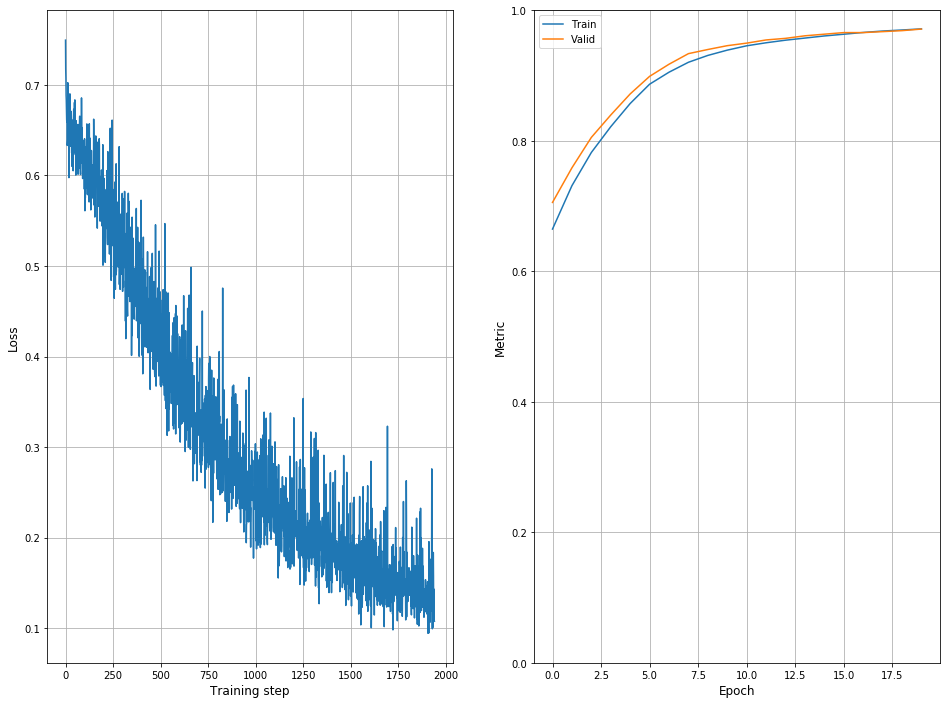

In [54]:
classifier.plot()